In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/kaggle/datasets/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/dog-and-cat-detection
! unzip dog-and-cat-detection.zip

In [220]:
! git clone https://github.com/einstalek/DL-models-experiments.git

Cloning into 'DL-models-experiments'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 9), reused 33 (delta 7), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [221]:
import sys
sys.path.append("./DL-models-experiments/")
from models.senet import SEUnetResnet50
from utils.augm import transform_fn, normalize_fn
from losses.losses import DICEMetrics, BCEDICELoss
from datasets.cat_dog_dataset import CatDogDataset, parse_xml

In [9]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [222]:
XML_ROOT = "./annotations/"
IMG_ROOT = "./images/"

In [223]:
def plot_bbox(box, c='red'):
    x1, y1, x2, y2 = map(int, box)
    plt.vlines(x1, y1, y2, color=c)
    plt.vlines(x2, y1, y2, color=c)
    plt.hlines(y1, x1, x2, color=c)
    plt.hlines(y2, x1, x2, color=c)

def load_sample(xml_fp):
    obj = parse_xml(os.path.join(XML_ROOT, xml_fp))
    img_fp = os.path.join(IMG_ROOT, obj['filename'])
    assert os.path.exists(img_fp)
    img = cv2.imread(img_fp)
    return obj, img[..., ::-1]

In [227]:
fps = [x for x in os.listdir(XML_ROOT) if '.xml' in x]
TRAIN, TEST = train_test_split(fps, test_size=0.1, random_state=1) 
data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST)
x, y = data[0]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([2, 128, 128]))

In [228]:
def train_single_epoch(unet, data_loader, b_size, epoch,criterion, optimizer):
    total_loss = 0.
    unet.train()
    unet.zero_grad()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
    
    for i, (img, mask) in tbar:
        img = img.cuda()
        mask = mask.cuda()
        out = unet(img)
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()
        total_loss = 0.5 * total_loss + 0.5 * loss.item()
        postfix_dict["train/loss"] = total_loss
        f_epoch = epoch + i / total_steps
        desc = '{:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    return total_loss
    
def evaluate_single_epoch(unet, data_loader, b_size, epoch, criterion):
    total_loss = 0.
    unet.eval()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
        
    with torch.no_grad():
        for i, (img, mask) in tbar:
            img = img.cuda()
            mask = mask.cuda()
            out = unet(img)
            loss = criterion(out, mask)
            total_loss = 0.5 * total_loss + 0.5 * loss.item()
            postfix_dict["val/dice"] = total_loss
            f_epoch = epoch + i / total_steps
            desc = '{:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
            tbar.set_description(desc)
            tbar.set_postfix(**postfix_dict)
    return total_loss
    
def save_model(model, epoch, name):
    fp = os.path.join("./", name + '.pth')
    ckpt = {'state_dict': model.state_dict(),
            'epoch': epoch}
    torch.save(ckpt, fp)

def train(epochs, b_size=16, shape=(256, 256)):
    train = CatDogDataset(XML_ROOT, IMG_ROOT, TRAIN, shape=shape, mask_scale=2, split='train')
    train_loader = DataLoader(train, batch_size=b_size, 
                             num_workers=8, drop_last=True, shuffle=True)
    test = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, shape=shape, mask_scale=2, split='val')
    test_loader = DataLoader(test, batch_size=b_size, 
                             num_workers=8, drop_last=True, shuffle=True)
    
    unet = SEUnetResnet50(activation='sigmoid', pretrained=True).cuda()
    
    criterion = BCEDICELoss()
    dice_metrics = DICEMetrics()
    lr = 5e-5
    optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
    prev_test_loss = None
    
    for epoch in range(epochs):
        train_single_epoch(unet, train_loader, b_size, epoch,
                           criterion, optimizer)
        total = evaluate_single_epoch(unet, test_loader, b_size, epoch, dice_metrics)
        if prev_test_loss is None or total > prev_test_loss:
            prev_test_loss = total
            save_model(unet, epoch, "unet")

In [ ]:
train(70, b_size=16)

In [229]:
unet = SEUnetResnet50(activation='sigmoid')
unet = unet.eval()

ckpt = torch.load("./se-unet-resnet50.pth")
unet.load_state_dict(ckpt['state_dict'])
print(ckpt['epoch'])

63


In [230]:
def post_process(out, mask_tresh=0.1, size_tresh=5):
    dets = []
    ch, h, w = out.shape
    for i in range(ch):
        temp = (out[i, :, :] > mask_tresh) * 255
        temp = temp.astype(np.uint8)
        num, labels, stats, cents = cv2.connectedComponentsWithStats(temp)     
        if len(stats) <= 1:
            continue
        for stat in stats[1:]:
            x1, y1, w, h, _ = stat
            if min(w, h) < size_tresh:
                continue
            x2, y2 = x1 + w, y1 + h
            box = (x1, y1, x2, y2)
            proba = out[i, int(y1):int(y2), int(x1):int(x2)].mean()
            dets.append([i, proba, 2. * np.array(box)])
    return dets

In [232]:
data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, shape=(256, 256), 
                     split='val', return_fp=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


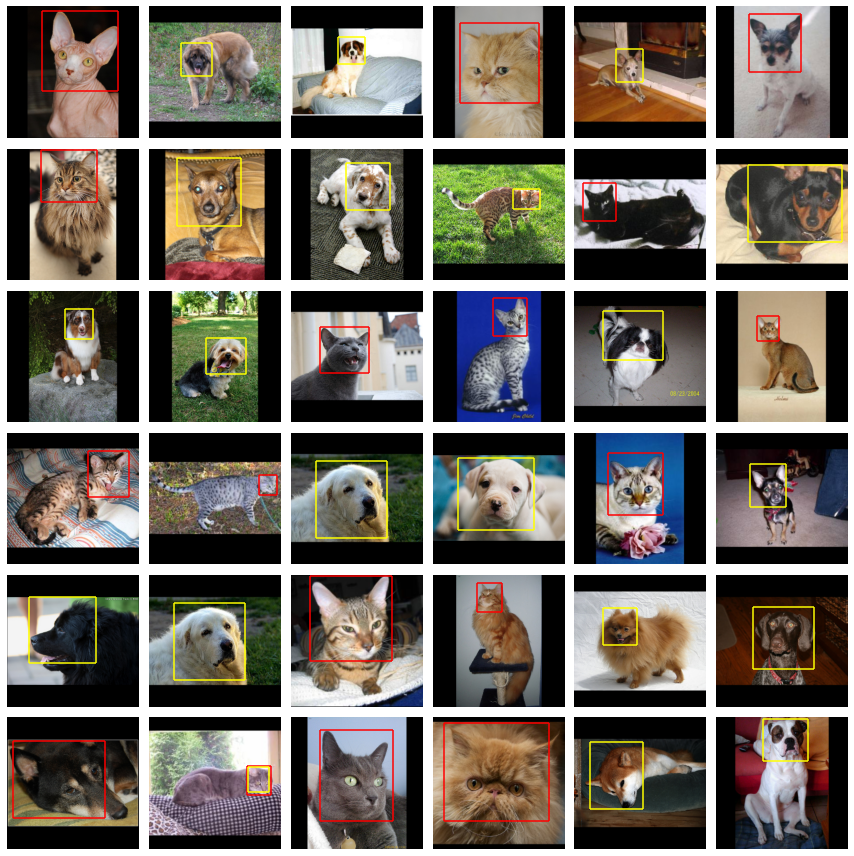

In [233]:
plt.figure(figsize=(12, 12))

random.seed(10)
ids = []
for i in range(36):
    idx = random.randint(0, len(data)-1)
    x, y, _ = data[idx]
    ids.append(idx)
    out = unet(x[None])
    img = 0.5 + 0.5 * x.detach().numpy().transpose(1, 2, 0)
    plt.subplot(6, 6, i+1)
    plt.imshow(img)
    dets = post_process(out[0].detach().cpu().numpy(), mask_tresh=0.8, size_tresh=15)
    for det in dets:
        cl, proba = det[:2]
        x1, y1, x2, y2 = det[2]
        color = 'red' if cl == 0 else 'yellow'
        pt = (x1, y1) if cl == 0 else (x2, y2)
        label = "Cat" if cl == 0 else "Dog"
        plot_bbox((x1, y1, x2, y2), color)
    plt.axis('off')
plt.tight_layout()

In [134]:
! git clone https://github.com/Cartucho/mAP

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [135]:
! rm ./mAP/input/detection-results/*
! rm ./mAP/input/ground-truth/*

In [234]:
def preprocess_image(img, bbox, shape=(256, 256)):
    pad_h, pad_w = 0, 0
    h, w, _ = img.shape
    if h > w:
        pad = int((h - w) / 2)
        pad_w = pad
        img = np.pad(img, ((0,  0), (pad, pad), (0, 0)))
    else:
        pad = int((w - h) / 2)
        pad_h = pad
        img = np.pad(img, ((pad, pad), (0,  0), (0, 0)))
    h, w, _ = img.shape
    img = cv2.resize(img, shape)
    H, W, _ = img.shape
    scale_x, scale_y = w / W, h / H
    x1, y1, x2, y2 = bbox
    x1, x2 = (x1 + pad_w) / scale_x, (x2 + pad_w) / scale_x
    y1, y2 = (y1 + pad_h) / scale_y, (y2 + pad_h) / scale_y
    return (pad_h, pad_w), (scale_x, scale_y)

In [212]:
for (x, y, xml_fp) in tqdm(data, leave=False, position=0):
    out = unet(x[None])
    dets = post_process(out[0].detach().cpu().numpy(), mask_tresh=0.8, size_tresh=15)
    ann, img = load_sample(xml_fp)
    (pad_h, pad_w), (scale_x, scale_y) = preprocess_image(img, ann['bbox'])
    
    fp = xml_fp.split('.')[0] + '.txt'
    with open(os.path.join("./mAP/input/detection-results", fp), "w") as f:
        for det in dets:
            cl, proba = det[:2]
            cl = "cat" if cl == 0 else "dog"
            x1, y1, x2, y2 = det[2]
            x1 *= scale_x
            x2 *= scale_x
            y1 *= scale_y
            y2 *= scale_y
            y1 -= pad_h
            y2 -= pad_h
            x1 -= pad_w
            x2 -= pad_w
            f.write("{} {} {} {} {} {}\n".format(cl, proba, x1, y1, x2, y2))
    with open(os.path.join("./mAP/input/ground-truth", fp), "w") as f:
        x1, y1, x2, y2 = ann['bbox']
        f.write("{} {} {} {} {}\n".format(ann['name'], x1, y1, x2, y2))

  0%|          | 0/369 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 369/369 [05:11<00:00,  1.19it/s]


In [214]:
! python mAP/scripts/extra/intersect-gt-and-dr.py

total ground-truth files: 369
total detection-results files: 369

No backup required for /content/mAP/input/ground-truth
No backup required for /content/mAP/input/detection-results
total intersected files: 369
Intersection completed!


In [235]:
! python mAP/main.py

95.19% = cat AP 
86.73% = dog AP 
mAP = 90.96%
<Figure size 640x480 with 1 Axes>
